In [5]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, HistoricAverage,RandomWalkWithDrift)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[************          25%%                      ]  2 of 8 completed

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-01-08,AAPL,0.013896
1,2019-01-15,AAPL,0.044463
2,2019-01-22,AAPL,-0.003322
3,2019-01-29,AAPL,0.091347
4,2019-02-05,AAPL,-0.010685
...,...,...,...
2075,2023-11-28,NVDA,-0.058298
2076,2023-12-05,NVDA,0.024248
2077,2023-12-12,NVDA,0.071470
2078,2023-12-19,NVDA,-0.025217


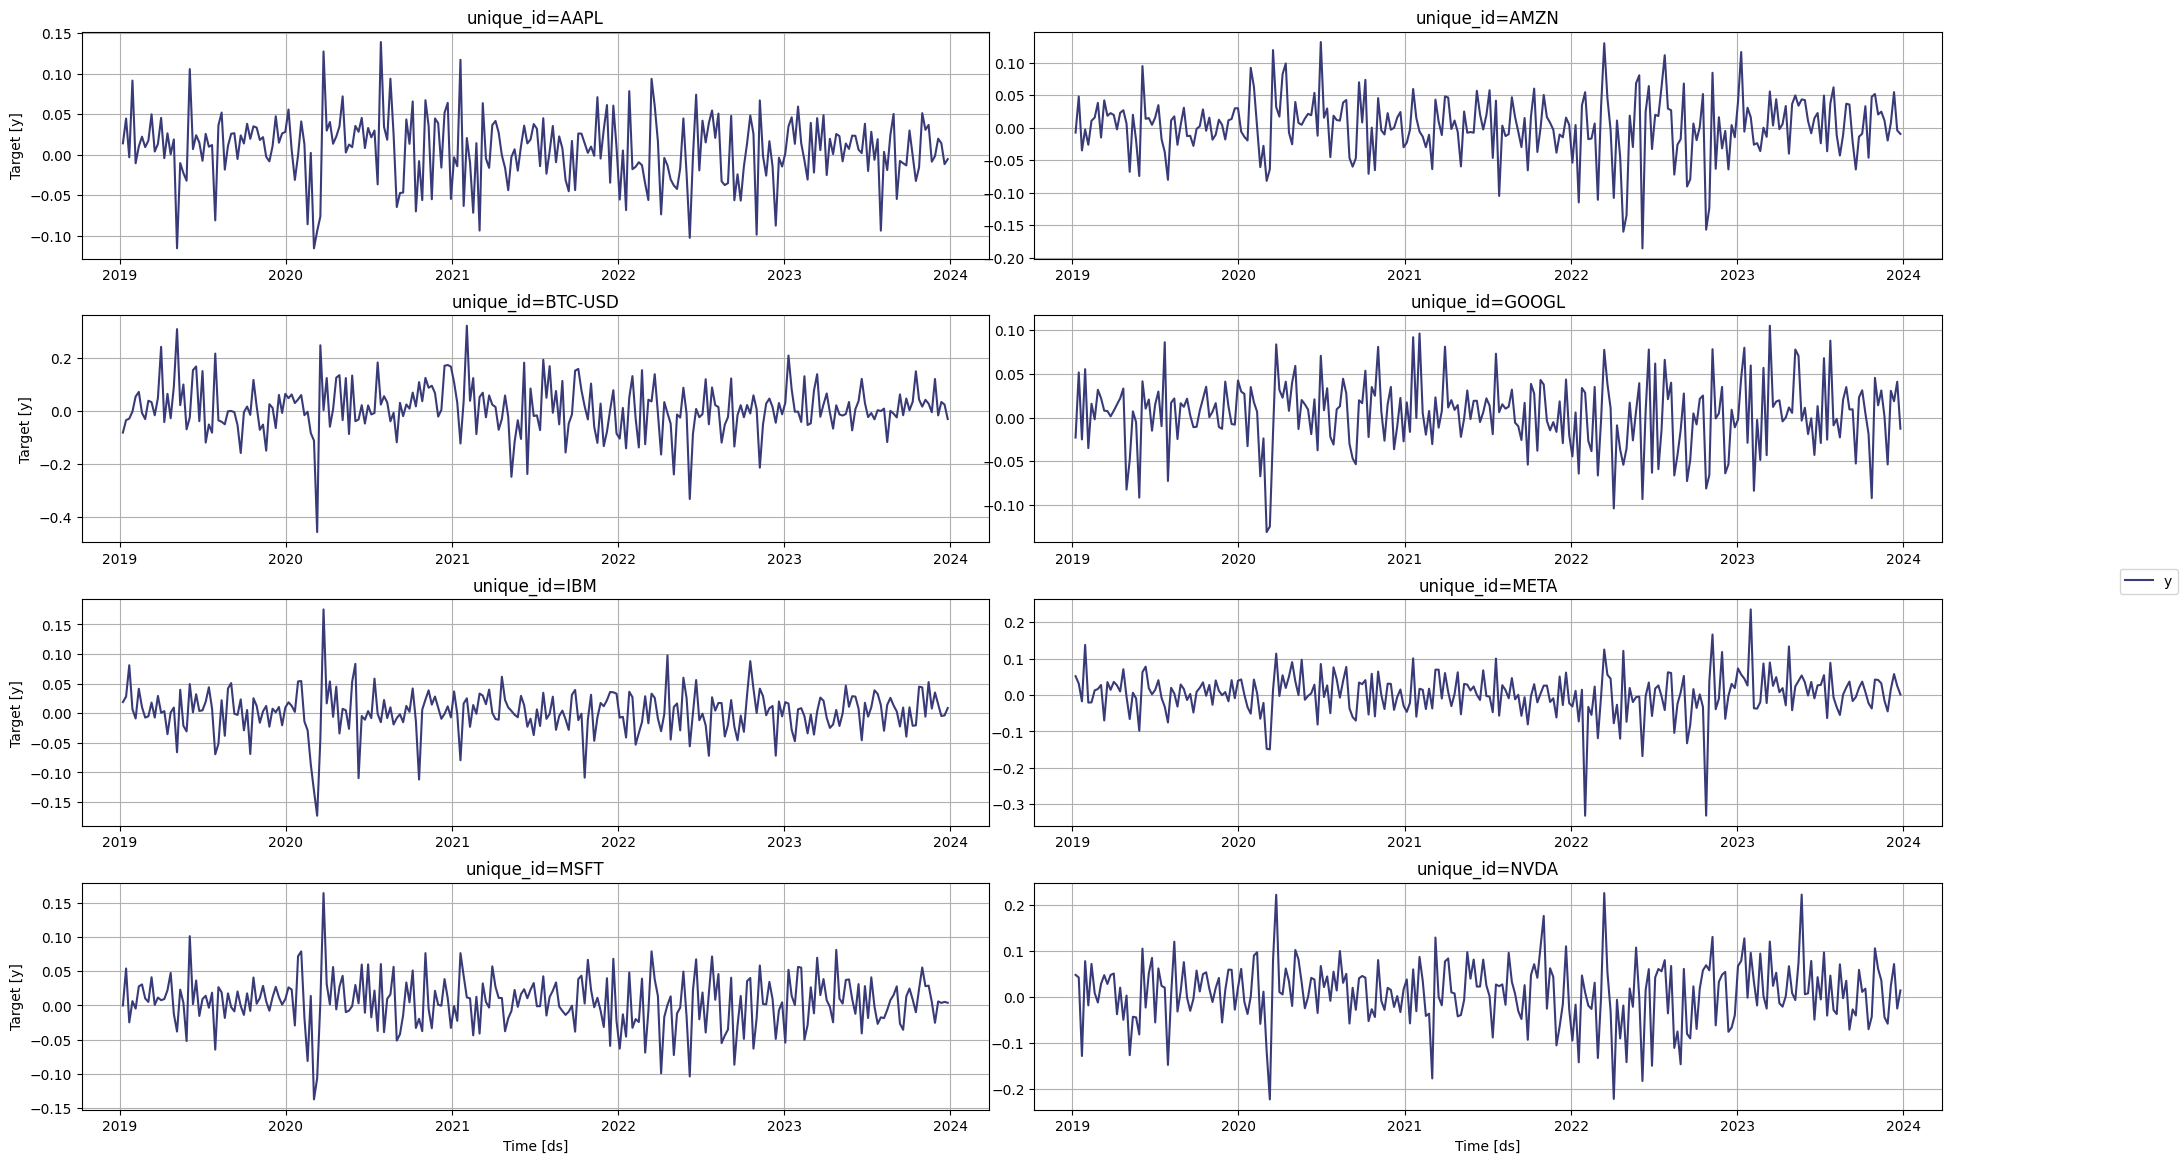

In [7]:
StatsForecast.plot(Y_df)

In [8]:
season_length = 52
horizon = 3

models = [
    Naive(),
    HistoricAverage(), 
    RandomWalkWithDrift(),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [9]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,HistoricAverage,RWD,SeasonalNaive
unique_id,,,,,
AAPL,2023-12-31,-0.005542,0.006503,-0.005617,0.001692
AAPL,2024-01-07,-0.005542,0.006503,-0.005692,0.034808
AAPL,2024-01-14,-0.005542,0.006503,-0.005767,0.046044
AMZN,2023-12-31,-0.009694,0.002397,-0.009702,0.039221
AMZN,2024-01-07,-0.009694,0.002397,-0.009710,0.116154


In [10]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,RWD,RWD-lo-90,RWD-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,
AAPL,2023-09-19,2023-09-12,-0.010677,-0.007780,-0.106668,0.091108,0.006575,-0.062498,0.075648,-0.007869,-0.106959,0.091222,-0.024309,-0.130460,0.081841
AAPL,2023-09-26,2023-09-12,-0.013321,-0.007780,-0.147629,0.132069,0.006575,-0.062498,0.075648,-0.007958,-0.148379,0.132463,-0.056764,-0.162915,0.049386
AAPL,2023-10-03,2023-09-12,0.029713,-0.007780,-0.179059,0.163499,0.006575,-0.062498,0.075648,-0.008046,-0.180375,0.164283,-0.014353,-0.120504,0.091797
AAPL,2023-10-10,2023-10-03,-0.001510,0.029713,-0.068677,0.128102,0.006518,-0.062230,0.075267,0.029777,-0.068812,0.128365,0.014072,-0.091525,0.119670
AAPL,2023-10-17,2023-10-03,-0.032529,0.029713,-0.109432,0.168857,0.006518,-0.062230,0.075267,0.029841,-0.109866,0.169547,0.048251,-0.057346,0.153849


In [11]:
cv_df.tail()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,RWD,RWD-lo-90,RWD-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,
NVDA,2023-11-28,2023-11-14,-0.058298,0.036135,-0.183573,0.255843,0.010437,-0.101991,0.122866,0.036042,-0.184533,0.256616,0.048288,-0.118453,0.215029
NVDA,2023-12-05,2023-11-14,0.024248,0.036135,-0.232951,0.305221,0.010437,-0.101991,0.122866,0.035995,-0.234682,0.306672,0.054450,-0.112291,0.221191
NVDA,2023-12-12,2023-12-05,0.071470,0.024248,-0.130655,0.179151,0.010012,-0.102124,0.122148,0.024155,-0.131050,0.179360,-0.075860,-0.242099,0.090379
NVDA,2023-12-19,2023-12-05,-0.025217,0.024248,-0.194818,0.243313,0.010012,-0.102124,0.122148,0.024063,-0.195857,0.243982,-0.066649,-0.232887,0.099590
NVDA,2023-12-26,2023-12-05,0.014072,0.024248,-0.244052,0.292547,0.010012,-0.102124,0.122148,0.023970,-0.245897,0.293837,-0.039710,-0.205949,0.126529


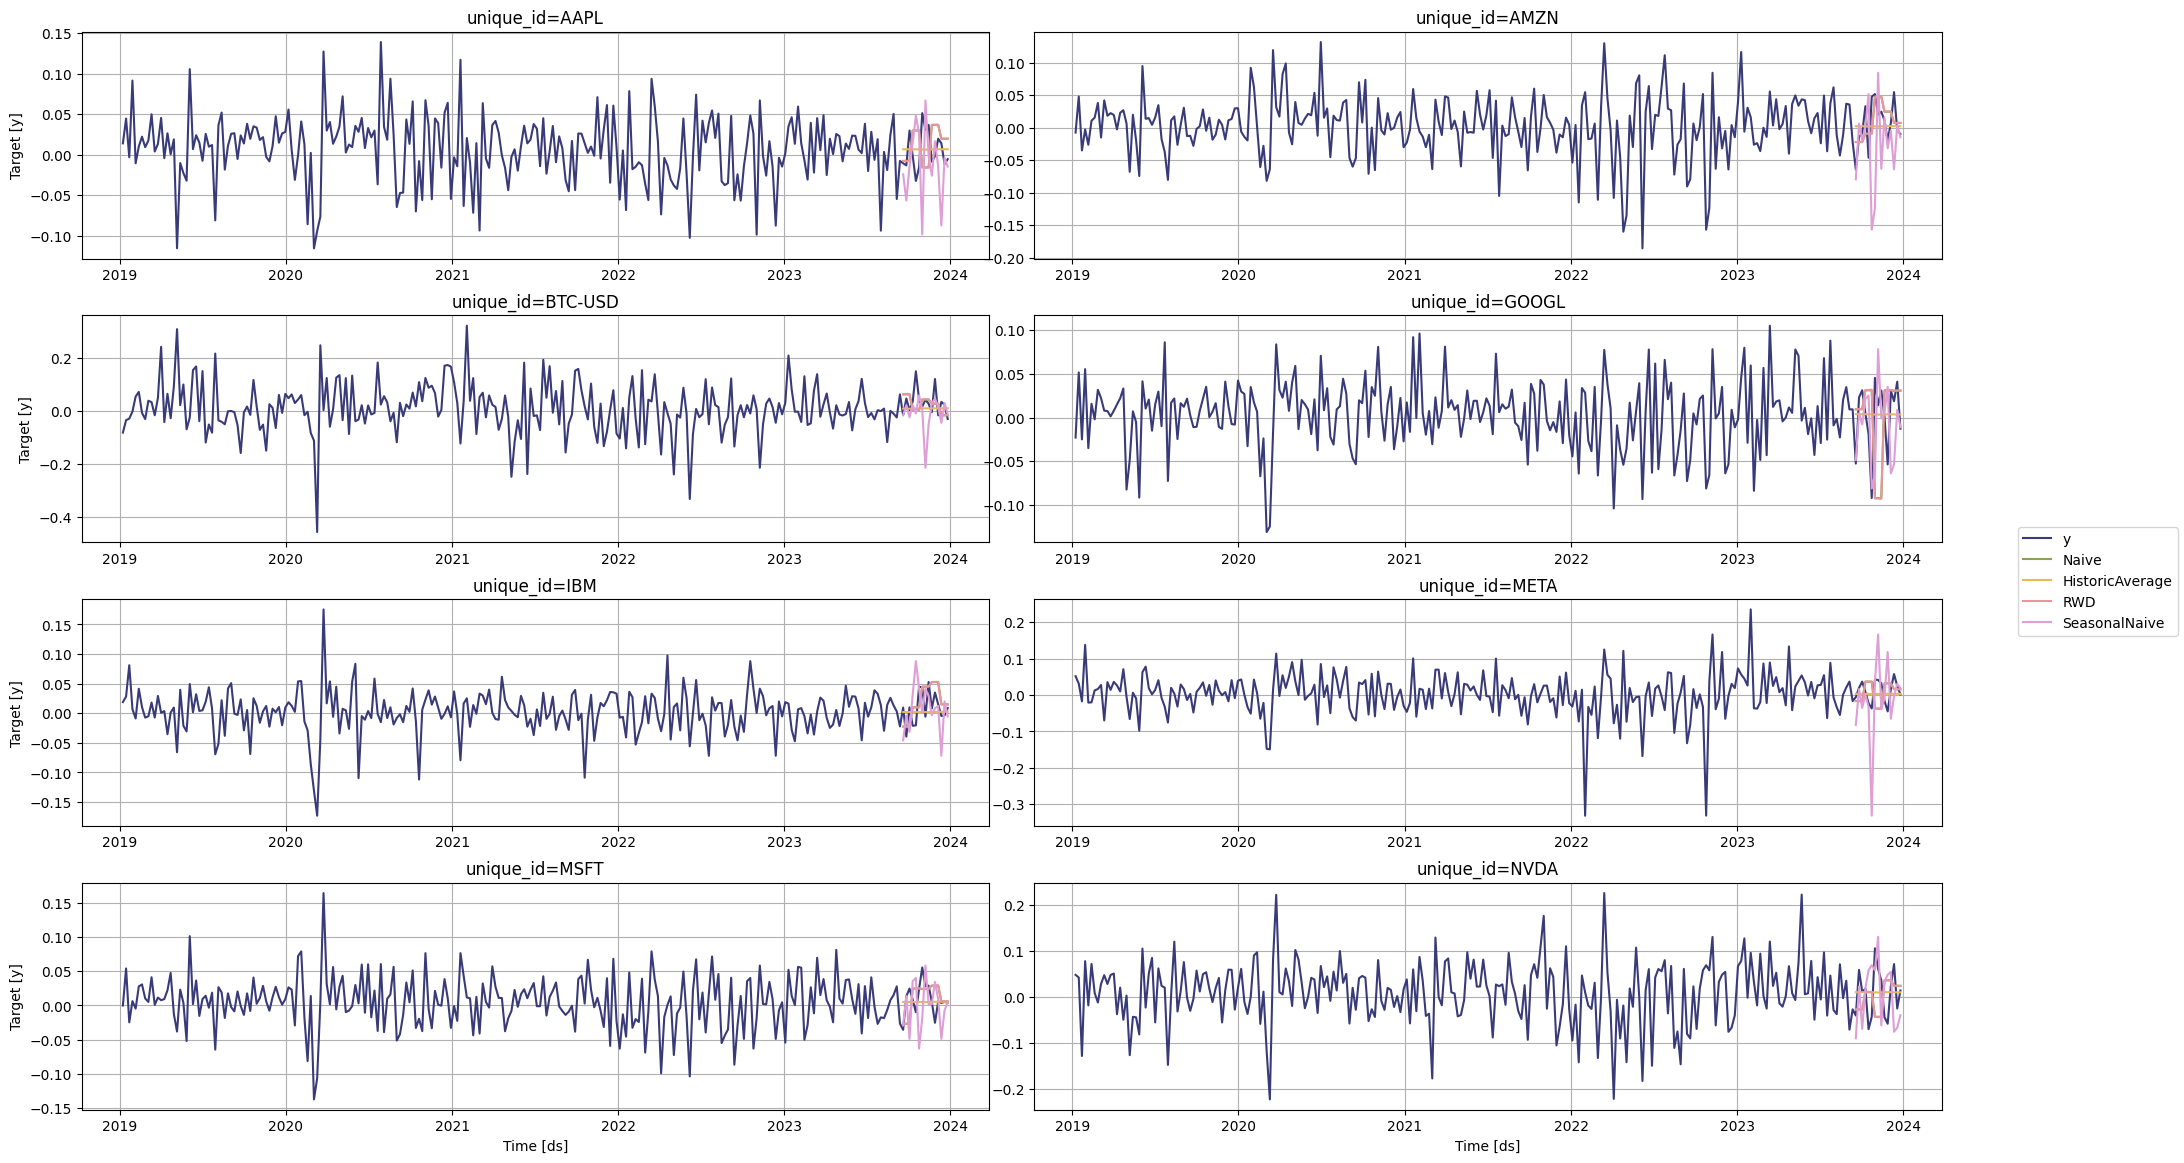

In [12]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [13]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [14]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [15]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [16]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [17]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 14:47:19,342 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1a699ce312ca1a4d084622be5a67a113 initialized by task ('shuffle-transfer-1a699ce312ca1a4d084622be5a67a113', 6) executed on worker tcp://127.0.0.1:56380
2024-07-09 14:47:22,403 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 1a699ce312ca1a4d084622be5a67a113 deactivated due to stimulus 'task-finished-1720529242.400287'


,unique_id,cutoff,metric,Naive,HistoricAverage,RWD,SeasonalNaive
0,AAPL,2023-12-05,mse,0.000549,0.000179,0.000551,0.003486
1,AAPL,2023-12-05,mae,0.020726,0.012608,0.020771,0.039547
2,AAPL,2023-12-05,smape,144.609406,157.172104,144.64621,130.622757
3,AMZN,2023-11-14,mse,0.000815,0.000195,0.000828,0.000107
4,AMZN,2023-11-14,mae,0.025071,0.011856,0.025325,0.009808


In [18]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive  HistoricAverage         RWD  SeasonalNaive
cutoff     metric                                                        
2023-09-12 mae        0.03247         0.025459    0.032759       0.032957
           mse       0.001577         0.000951    0.001608       0.001699
           smape    130.74263       159.862976  130.454361     118.873955
2023-10-03 mae       0.047672         0.035562    0.047642       0.067137
           mse        0.00332          0.00225    0.003314       0.009579
           smape   168.098572       164.320084  167.658264     144.258987
2023-10-24 mae        0.05374         0.033568    0.054156       0.073531
           mse       0.004885         0.001472    0.004942       0.008588
           smape   126.078163       152.152634   126.30114     149.887344
2023-11-14 mae       0.041217         0.025453    0.041392       0.041463
           mse       0.002406           0.0013    0.002413        0.00343
           smape   143.289459       151.014587  143.429413      141.94931
2023-12-05 mae       0.022066         0.019037    0.022086       0.039758
           mse       0.000767         0.000682    0.000767       0.003159
           smape   122.595215       138.598618  122.833107     139.403015

In [19]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

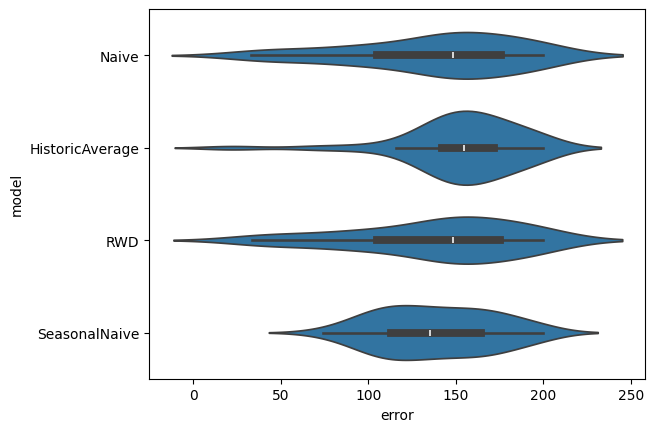

In [20]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

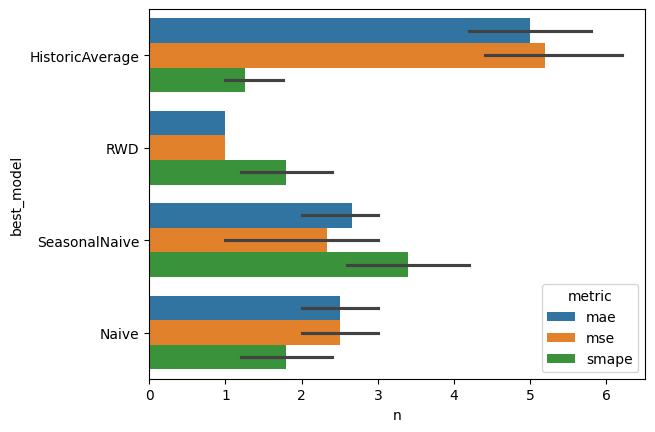

In [21]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')